## Code starting here: 

## Import general dependencies and define helper functions:

In [2]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.linear_model import Ridge, LassoCV, RidgeCV, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


 ## Loading in the data and validating the data:

In [3]:
account_data_df = pd.read_csv('account_data.csv')
print('Shape of account data dataframe:')
account_data_df.shape
print('Number of unique account_idx:')
account_data_df.account_idx.nunique()

Shape of account data dataframe:


(1125, 6)

Number of unique account_idx:


1119

In [4]:
opp_data_df = pd.read_csv('opportunity_data.csv')
print('Shape of opportunity dataframe:')
opp_data_df.shape
print('Number of unique account_idx:')
opp_data_df.account_idx.nunique()


Shape of opportunity dataframe:


(23447, 10)

Number of unique account_idx:


1119

### Number of missing values in each column

In [5]:
print('---------account data--------')
account_data_df.isna().sum()
print('----------opporunity data--------')
opp_data_df.isna().sum()

---------account data--------


account_idx               0
us_nm_region             32
cec                       0
cnes_target_account       0
gtm_wave               1056
n_activities             97
dtype: int64

----------opporunity data--------


create_date               0
create_year               0
implant_date           4944
age                       0
stage                     0
implanted                 0
implant_number            4
days_opp_to_piq       12166
days_consult_to_or     8791
account_idx               0
dtype: int64

## The following data cleaning steps will be performed:

#### 1. gtm_wave variable in account_data will be dropped because of (1056 / 1125) missing values and it has values greater than the max of 1 as defined in the instructions.
#### 2. We will fill NAs in us_nm_region with "other"
#### 3. We will fill NAs in n_activities with 0: assuming NA in current activities means no current activities
#### 4. Duplicated entries in account_idx (there are 6) will be dropped: I verified these entries are truly due to duplication.
#### 5. Creating a new variable called "implant_create_diff" defined as implant_date - create_date
#### 6. We will further deal with other variables such as days_opp_to_piq and days_consult_to_or during modeling.


In [38]:
# Step 1
account_data_df.drop(['gtm_wave'], axis = 1, inplace = True) 
# Step 2
account_data_df['us_nm_region'] = account_data_df['us_nm_region'].fillna('other')
# Step 3
account_data_df['n_activities'] = account_data_df['n_activities'].fillna('0')
# Step 4 
account_data_df.drop_duplicates(subset = ["account_idx"],inplace=True)
# Step 5
opp_data_df[['implant_date','create_date']] = opp_data_df[['implant_date','create_date']].apply(pd.to_datetime)
opp_data_df['implant_create_diff'] = (opp_data_df['implant_date'] - opp_data_df['create_date']).dt.days

account_data_df['n_activities'] = account_data_df['n_activities'].astype(float)


### We will left join opportunity data with account data on account_idx: making sure all rows in opportunity data are perserved

In [39]:
joined_data = pd.merge(opp_data_df, account_data_df, how="right", on=["account_idx"])
joined_data.shape

(23447, 15)

# 1. EDA

## 1.1) What factors are associated with whether an opportunity is converted to implant?

### I found that a higher percentage of adult opportunities will convert to implant (83%) versus peds opportunities (64%) as shown from the table：

In [16]:
grouped_by_age_implanted = joined_data.groupby(['age','implanted']).count().reset_index()
grouped_by_age_implanted['percentage'] = grouped_by_age_implanted['create_date'].div(
    grouped_by_age_implanted.groupby('age')['create_date'].transform(lambda x: x.sum()))
grouped_by_age_implanted = grouped_by_age_implanted[['age','implanted','percentage']]
print("age within group implant percentage:")
grouped_by_age_implanted
del grouped_by_age_implanted

age within group implant percentage:


,age,implanted,percentage
0,Adult,False,0.168436
1,Adult,True,0.831564
2,Peds,False,0.354116
3,Peds,True,0.645884


### I found that a higher percentage of opportunities at NAEC comprehensive epilepsy center will convert to implant (87%) versus patients at non-cec (71%) as shown from the table below：

In [17]:
grouped_by_cec_implanted = joined_data.groupby(['cec','implanted']).count().reset_index()
grouped_by_cec_implanted['percentage'] = grouped_by_cec_implanted['create_date'].div(
    grouped_by_cec_implanted.groupby('cec')['create_date'].transform(lambda x: x.sum()))
grouped_by_cec_implanted = grouped_by_cec_implanted[['cec','implanted','percentage']]
print("cec within group implant percentage:")
grouped_by_cec_implanted
del grouped_by_cec_implanted

cec within group implant percentage:


,cec,implanted,percentage
0,0,False,0.289136
1,0,True,0.710864
2,1,False,0.129024
3,1,True,0.870976


### I found that a higher percentage of opportunities targeted by clinical nursing specialists will convert to implant (89%) versus opportunities not targeted (78%) as shown from the table below：

In [18]:
grouped_by_cnes_target_account_implanted = joined_data.groupby(['cnes_target_account','implanted']).count().reset_index()
grouped_by_cnes_target_account_implanted['percentage'] = grouped_by_cnes_target_account_implanted['create_date'].div(
    grouped_by_cnes_target_account_implanted.groupby('cnes_target_account')['create_date'].transform(lambda x: x.sum()))
grouped_by_cnes_target_account_implanted = grouped_by_cnes_target_account_implanted[['cnes_target_account','implanted','percentage']]
print("cnes_target_account within group implant percentage:")
grouped_by_cnes_target_account_implanted
del grouped_by_cnes_target_account_implanted

cnes_target_account within group implant percentage:


,cnes_target_account,implanted,percentage
0,0,False,0.219444
1,0,True,0.780556
2,1,False,0.110449
3,1,True,0.889551


### I found that the lowest implant conversion percentage is at NA geographic regions where I arbitrarily filled as "other". In other words, almost no implants occur when the geographical region is not specified. Moreover, opportunities in north central and northwest also result in higher percentages of implants.

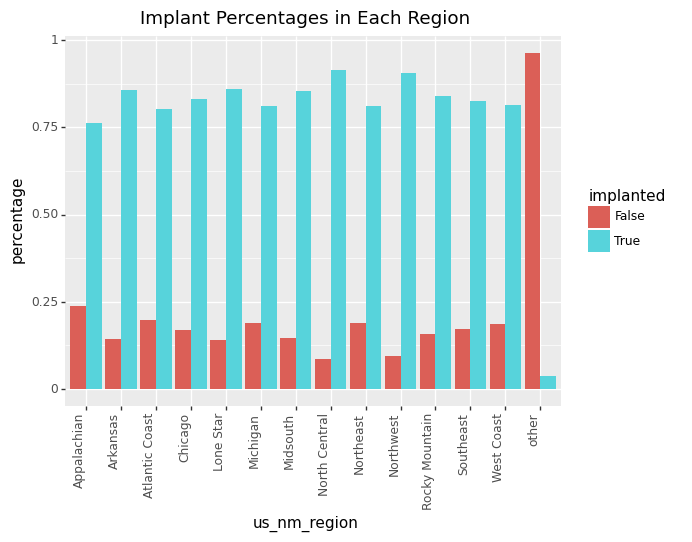

<ggplot: (127516257380)>

In [14]:
grouped_by_us_nm_region_implanted = joined_data.groupby(['us_nm_region','implanted']).count().reset_index()
grouped_by_us_nm_region_implanted['percentage'] = grouped_by_us_nm_region_implanted['create_date'].div(
    grouped_by_us_nm_region_implanted.groupby('us_nm_region')['create_date'].transform(lambda x: x.sum()))
grouped_by_us_nm_region_implanted = grouped_by_us_nm_region_implanted[['us_nm_region','implanted','percentage']]
(ggplot(grouped_by_us_nm_region_implanted, aes(x='us_nm_region', y='percentage', fill='implanted'))
 + geom_col(stat='identity', position='dodge')
 +  theme(axis_text_x=element_text(rotation=90, hjust=1))
 + ggtitle('Implant Percentages in Each Region'))     

### --------------------------------------End of EDA 1.1) ---------------------------------------------

## 1.2) What factors are associated with an opportunity’s time to implant?

### We observe from the boxplots that opportunities at CEC will tend to have a shorter median time to implant compared to non-CEC opportunities (36 vs 49 days)

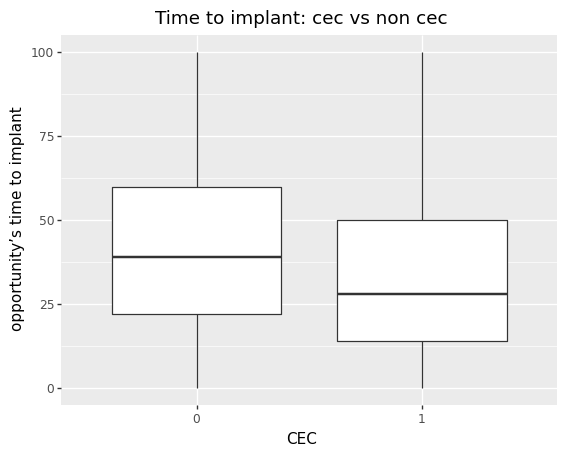

<ggplot: (127528991738)>

CEC Opporunitiy Median Time to Implant
36.0
Non-CEC Opporunitiy Median Time to Implant
49.0


In [24]:
(
    ggplot(joined_data)
    + geom_boxplot(aes(x='factor(cec)', y='implant_create_diff'))
    + ylim(0,100)
    + ylab("opportunity’s time to implant")
    + xlab('CEC')
    + ggtitle('Time to implant: cec vs non cec')
)
print("CEC Opporunitiy Median Time to Implant")
print(joined_data.query("cec == 1 & implant_create_diff > 0 ").implant_create_diff.median())
print("Non-CEC Opporunitiy Median Time to Implant")
print(joined_data.query("cec == 0 & implant_create_diff > 0 ").implant_create_diff.median())

### We observe from the boxplots that peds opportunities will tend to have a shorter median time to implant compared to adult opportunities (36 vs 44 days)

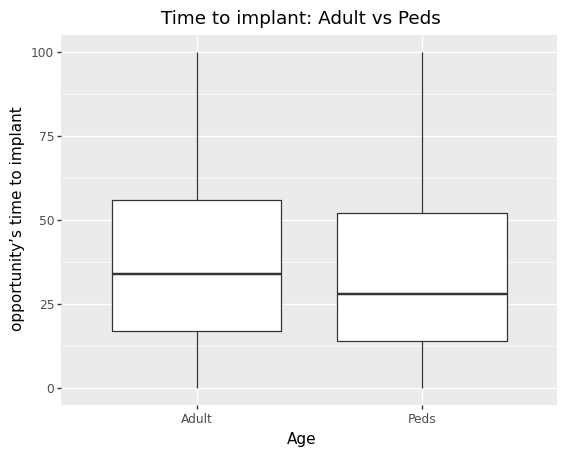

<ggplot: (127529052495)>

Adult Opporunitiy Median Time to Implant
44.0
Peds Opporunitiy Median Time to Implant
36.0


In [28]:
(
    ggplot(joined_data)
    + geom_boxplot(aes(x='factor(age)', y='implant_create_diff'))
    + ylim(0,100)
    + ylab("opportunity’s time to implant")
    + xlab('Age')
    + ggtitle('Time to implant: Adult vs Peds')
)
print("Adult Opporunitiy Median Time to Implant")
print(joined_data.query("age == 'Adult' & implant_create_diff > 0 ").implant_create_diff.median())
print("Peds Opporunitiy Median Time to Implant")
print(joined_data.query("age != 'Adult' & implant_create_diff > 0 ").implant_create_diff.median())

### We observe from the boxplots that time to implant significant decreases after the 5th battery change

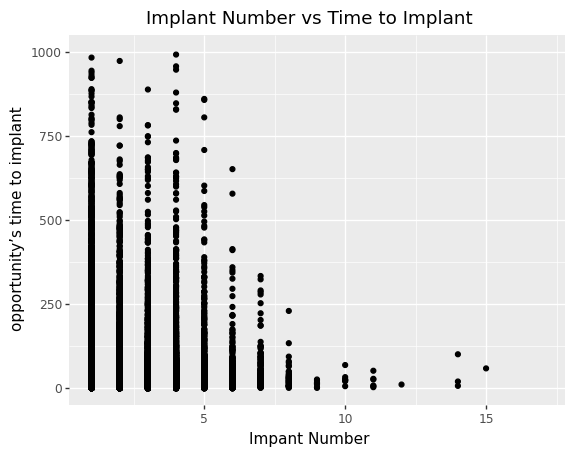

<ggplot: (172491187092)>

In [467]:
(
    ggplot(joined_data)
    + geom_point(aes(x='implant_number', y='implant_create_diff'))
    + ylim(0,1000)
    + ylab("opportunity’s time to implant")
    + xlab('Impant Number')
    + ggtitle('Implant Number vs Time to Implant')
)

### We observe from the boxplots that opportunities in regions such as Arkansas and North East will have a shorter time to implant

c:\Users\kylek\anaconda3\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_boxplot : Removed 8719 rows containing non-finite values.


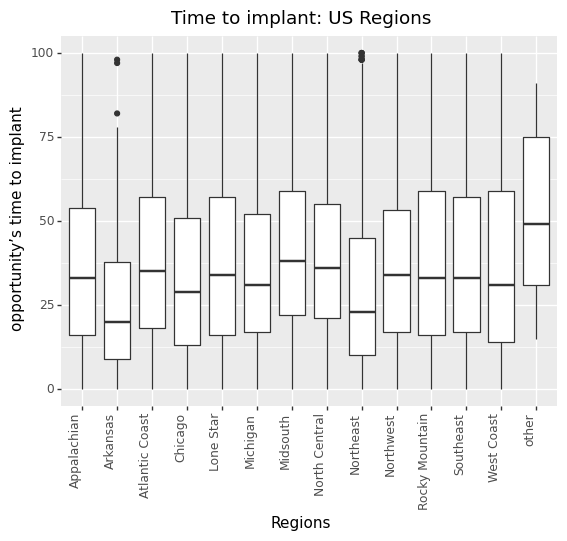

<ggplot: (172518581038)>

In [12]:
(
    ggplot(joined_data)
    + geom_boxplot(aes(x='factor(us_nm_region)', y='implant_create_diff'))
    + ylim(0,100)
    + ylab("opportunity’s time to implant")
    + xlab('Regions')
    + ggtitle('Time to implant: US Regions')
    +  theme(axis_text_x=element_text(rotation=90, hjust=1)))


### --------------------------------------End of EDA 1.2) ----------------------------------------------------

## 1.3) What other data might you want to include in this analysis, if possible?

### There are many other variables that could be helpful in my opinion. Here is my list:

### 1. Information regarding the type of device implanted
### 2. Whether implant can be covered by insurance. If so, how much is covered?
### 3. Clinical variables such as ICD 10 codes.
### 4. More patient demographic information such as sex, race, and more granular geographic information.
### 5. Variables linked to social determinants of health
